In [1]:
from data_utils import generateDataset
train_dataloader = generateDataset(dataPath='./dataset/snli_1.0_train.jsonl', isTrain=True)
val_dataloader = generateDataset(dataPath='./dataset/snli_1.0_dev.jsonl', isTrain=False)
print("length of train loader: {}".format(len(train_dataloader)))
print("length of val loader: {}".format(len(val_dataloader)))

length of train loader: 17168
length of val loader: 308


In [2]:
next(iter(train_dataloader))

[tensor([[ 101, 1037, 2158,  ...,    0,    0,    0],
         [ 101, 1037, 2158,  ...,    0,    0,    0],
         [ 101, 1016, 2308,  ...,    0,    0,    0],
         ...,
         [ 101, 1037, 2158,  ...,    0,    0,    0],
         [ 101, 1996, 3628,  ...,    0,    0,    0],
         [ 101, 2048, 4715,  ...,    0,    0,    0]], dtype=torch.int32),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([0, 2, 0, 0, 2, 2, 1, 0, 1, 1, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2,
         0, 0, 0, 1, 1, 1, 0, 1])]

# NOTE
### In this notebook, we used dataset (SNLI) to further validate our conclusion, this is a classification work. It considers the problem on inference, where a pair of sentences (a premise and a hypothesis) are given and we have to classify them as entailment, neutral, negative. If the result is entailment, it means that premise can infer hypothesis. If negative, premise can't infer hypothesis. 

In [3]:
from data_utils import generateDataset
train_dataloader = generateDataset(dataPath='./dataset/snli_1.0_train.jsonl', isTrain=True)
val_dataloader = generateDataset(dataPath='./dataset/snli_1.0_dev.jsonl', isTrain=False)
print("length of train loader: {}".format(len(train_dataloader)))
print("length of val loader: {}".format(len(val_dataloader)))

length of train loader: 17168
length of val loader: 308


# Fine tuning BERT

In [4]:
from transformers import AdamW, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.cuda()
print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [5]:
import torch
from train_epoch import evaluate
import torch.nn as nn
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# loss_fn = nn.CrossEntropyLoss()
# t_begin = time.time()
# val_loss, val_acc = evaluate(model, loss_fn, val_dataloader, device, is_pretrained=True)
# time_elapsed = time.time() - t_begin
# print(f"{'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
# print("-" * 35)
# print(f"{val_loss:^10.6f} | {val_acc:^9.2f} | {time_elapsed:^9.2f}")

cuda:0


In [6]:
from transformers import get_linear_schedule_with_warmup
from train_epoch import train, evaluate, bert_predict

epochs = 2
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()
total_steps = len(train_dataloader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses, val_losses, val_acc = train(model, loss_fn, optimizer, scheduler, train_dataloader, val_dataloader, epochs=epochs, evaluation=True, device=device, FINETUNE=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   0.838240   |     -      |     -     |   37.52  
   1    |   400   |   0.625384   |     -      |     -     |   35.10  
   1    |   600   |   0.589157   |     -      |     -     |   35.23  
   1    |   800   |   0.545320   |     -      |     -     |   35.28  
   1    |  1000   |   0.539769   |     -      |     -     |   35.35  
   1    |  1200   |   0.520024   |     -      |     -     |   35.42  
   1    |  1400   |   0.507054   |     -      |     -     |   35.44  
   1    |  1600   |   0.487531   |     -      |     -     |   35.43  
   1    |  1800   |   0.492652   |     -      |     -     |   35.44  
   1    |  2000   |   0.490036   |     -      |     -     |   35.48  
   1    |  2200   |   0.456009   |     -      |     -     |   35.51  
   1    |  2400   |   0.468178   |     -      |     -     |   35.48  


   2    |  5000   |   0.259858   |     -      |     -     |   35.44  
   2    |  5200   |   0.270202   |     -      |     -     |   35.42  
   2    |  5400   |   0.258191   |     -      |     -     |   35.44  
   2    |  5600   |   0.253556   |     -      |     -     |   35.42  
   2    |  5800   |   0.263675   |     -      |     -     |   35.41  
   2    |  6000   |   0.251296   |     -      |     -     |   35.46  
   2    |  6200   |   0.255036   |     -      |     -     |   35.43  
   2    |  6400   |   0.255753   |     -      |     -     |   35.43  
   2    |  6600   |   0.265170   |     -      |     -     |   35.44  
   2    |  6800   |   0.263720   |     -      |     -     |   35.44  
   2    |  7000   |   0.262774   |     -      |     -     |   35.43  
   2    |  7200   |   0.260200   |     -      |     -     |   35.43  
   2    |  7400   |   0.257238   |     -      |     -     |   35.45  
   2    |  7600   |   0.271540   |     -      |     -     |   35.44  
   2    |  7800   | 

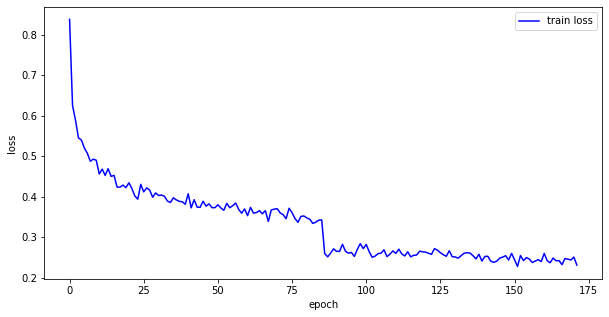

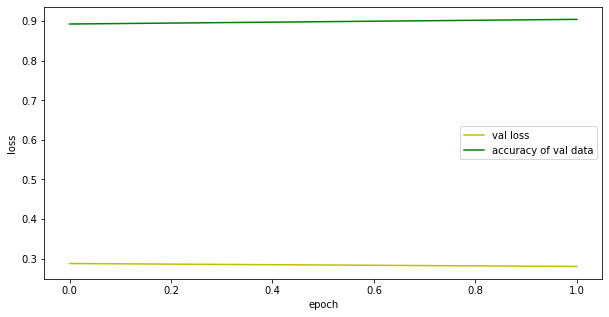

In [7]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train loss", c='b')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_losses, label="val loss", c='y')
plt.plot(val_acc, label="accuracy of val data", c='g')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# Test on Model (Finetune BERT)

In [8]:
label = ['entailment', 'neutral', 'contradiction']

def bertPredict(model, b_input_ids, b_attn_mask, FINETUNE):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    with torch.no_grad():
        logits = model(b_input_ids, b_attn_mask)
        if FINETUNE:
            logits = logits["logits"]
    preds = torch.argmax(logits, dim=1).flatten()
    predictions = []
    for pred in preds.cpu().numpy():
        predictions.append(label[pred])
    return predictions

def evaluateRandomly(model, test_dataloader, n=1, FINETUNE=False):
    for i, sample in enumerate(test_dataloader):
        if i > n: break
            
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in sample)
        predict = bertPredict(model, b_input_ids, b_attn_mask, FINETUNE)
        b_labels = b_labels.cpu().numpy()
        for i, pred in enumerate(b_labels):
            print("label: {} --- predict: {}".format(label[b_labels[i]], predict[i]))

In [9]:
from train_epoch import evaluate

test_dataloader = generateDataset(dataPath='./dataset/snli_1.0_test.jsonl', isTrain=False)
test_loss, test_acc = evaluate(model, loss_fn, test_dataloader, device=device, FINETUNE=True)
print("Accuracy on test dataset: {}".format(test_acc))
evaluateRandomly(model, test_dataloader, FINETUNE=True)

Accuracy on test dataset: 90.45195439739413
label: neutral --- predict: contradiction
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: neutral --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: entailment --- predict: entailment
label: neutral --- predict: neutral
label: contradiction --- predict: contradiction
label: neutral --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: entailment --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: contradiction --- predict: contradiction
label: entailment --- predict: entailment
label: neutral --- predict: neutral
label: entailment --- predict: contradiction
label: contradiction --- predict: contradiction
label: neutral --- predict: entailment
label: contradiction --- predict: contradiction
label: enta

# Remove Layer 12 in BERT

In [10]:
from load_model import BertClassifier
from train_epoch import train, evaluate, bert_predict
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch.nn as nn
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BertClassifier(freeze_bert=False)
print(model)
model.to(device)
epochs = 2

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()
total_steps = len(train_dataloader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [11]:
print(device)
train_losses, val_losses, val_acc = train(model, loss_fn, optimizer, scheduler, train_dataloader, val_dataloader, epochs=epochs, evaluation=True, device=device)

cuda:0
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   0.809586   |     -      |     -     |   32.63  
   1    |   400   |   0.609162   |     -      |     -     |   32.58  
   1    |   600   |   0.570329   |     -      |     -     |   32.57  
   1    |   800   |   0.544479   |     -      |     -     |   32.58  
   1    |  1000   |   0.534167   |     -      |     -     |   32.58  
   1    |  1200   |   0.508499   |     -      |     -     |   32.58  
   1    |  1400   |   0.501441   |     -      |     -     |   32.59  
   1    |  1600   |   0.478903   |     -      |     -     |   32.60  
   1    |  1800   |   0.461566   |     -      |     -     |   32.61  
   1    |  2000   |   0.474568   |     -      |     -     |   32.57  
   1    |  2200   |   0.451919   |     -      |     -     |   32.59  
   1    |  2400   |   0.444115   |     -      |     -     |   3

   2    |  5000   |   0.260939   |     -      |     -     |   32.60  
   2    |  5200   |   0.262198   |     -      |     -     |   32.59  
   2    |  5400   |   0.270749   |     -      |     -     |   32.60  
   2    |  5600   |   0.264257   |     -      |     -     |   32.60  
   2    |  5800   |   0.255035   |     -      |     -     |   32.58  
   2    |  6000   |   0.252058   |     -      |     -     |   32.57  
   2    |  6200   |   0.260465   |     -      |     -     |   32.56  
   2    |  6400   |   0.259680   |     -      |     -     |   32.57  
   2    |  6600   |   0.271293   |     -      |     -     |   32.58  
   2    |  6800   |   0.252020   |     -      |     -     |   32.60  
   2    |  7000   |   0.264054   |     -      |     -     |   32.58  
   2    |  7200   |   0.249459   |     -      |     -     |   32.59  
   2    |  7400   |   0.239247   |     -      |     -     |   32.59  
   2    |  7600   |   0.249089   |     -      |     -     |   32.59  
   2    |  7800   | 

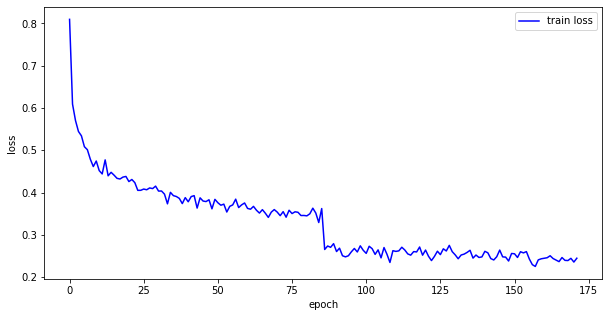

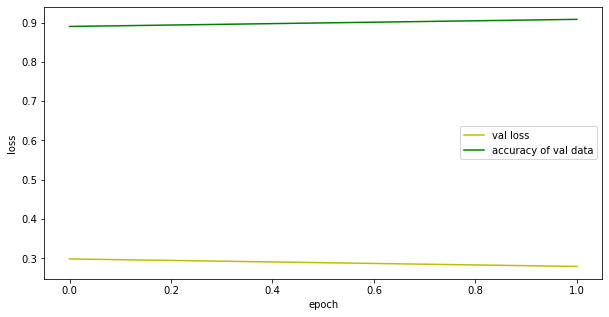

In [12]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="train loss", c='b')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_losses, label="val loss", c='y')
plt.plot(val_acc, label="accuracy of val data", c='g')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# Test on Model (remove layer 12)

In [13]:
label = ['entailment', 'neutral', 'contradiction']

def bertPredict(model, b_input_ids, b_attn_mask, FINETUNE):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    with torch.no_grad():
        logits = model(b_input_ids, b_attn_mask)
        if FINETUNE:
            logits = logits["logits"]
    preds = torch.argmax(logits, dim=1).flatten()
    predictions = []
    for pred in preds.cpu().numpy():
        predictions.append(label[pred])
    return predictions


def evaluateRandomly(model, test_dataloader, n=1, FINETUNE=False):
    for i, sample in enumerate(test_dataloader):
        if i > n: break
            
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in sample)
        predict = bertPredict(model, b_input_ids, b_attn_mask, FINETUNE)
        b_labels = b_labels.cpu().numpy()
        for i, pred in enumerate(b_labels):
            print("label: {} --- predict: {}".format(label[b_labels[i]], predict[i]))

In [14]:
test_dataloader = generateDataset(dataPath='./dataset/snli_1.0_test.jsonl', isTrain=False)
test_loss, test_acc = evaluate(model, loss_fn, test_dataloader, device=device, FINETUNE=False)
print("Accuracy on test dataset: {}".format(test_acc))
evaluateRandomly(model, test_dataloader)

Accuracy on test dataset: 90.32980456026058
label: neutral --- predict: contradiction
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: neutral --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: entailment --- predict: entailment
label: neutral --- predict: neutral
label: contradiction --- predict: contradiction
label: neutral --- predict: contradiction
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: entailment --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: contradiction --- predict: contradiction
label: entailment --- predict: entailment
label: neutral --- predict: neutral
label: entailment --- predict: entailment
label: contradiction --- predict: contradiction
label: neutral --- predict: entailment
label: contradiction --- predict: contradiction
label: e